In [324]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

from scipy.optimize import quadratic_assignment#
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

# Graph extraction

In [325]:
file = pd.read_excel('Reduction Sequences/sequence_data_1-22-2024.xlsx')

In [326]:
refits = []

for index, row in file.iterrows():
    refit = row.iloc[0][:6]
    if refit not in refits: refits.append(refit)

print(refits)

['BT.1.4', 'BT.1.A', 'BT.1.C', 'BT.1.F', 'BT.2.6', 'BT.2.U', 'T-1_A_', 'T-1_18', 'T-1_19', 'T-1_47', 'T-1_57']


In [327]:
edge_lists = {refit:{} for refit in refits}

for i, row in file.iterrows():
    refit = row.iloc[0][:6]
    flake = row.iloc[0]
    edge_lists[refit][flake] = []
    j = 14
    while type(row.iloc[j])==str:
        edge_lists[refit][flake].append(row.iloc[j])
        j += 1

print(edge_lists[refits[0]])

{'BT.1.4-25.01': ['BT.1.4-25.02'], 'BT.1.4-25.02': ['BT.1.4-25.03'], 'BT.1.4-25.03': ['BT.1.4-25.04'], 'BT.1.4-25.04': ['BT.1.4-25.05'], 'BT.1.4-25.05': []}


In [328]:
graphs = {refit:{} for refit in refits}
adjacency_mat = {refit:{} for refit in refits}

for refit in refits:
    graphs[refit] = nx.DiGraph(edge_lists[refit])
    a = nx.to_numpy_array(graphs[refit])
    for i in range(len(a)): 
        for j in range(i+1, len(a)):
            if a[i, j]>0. and a[j, i]>0.: a[i, j], a[j, i] = 0., 0. #discarding undirected edges
    adjacency_mat[refit] = a
    graphs[refit] = nx.DiGraph(adjacency_mat[refit])

# Visualization

['BT.1.4', 'BT.1.A', 'BT.1.C', 'BT.1.F', 'BT.2.6', 'BT.2.U', 'T-1_A_', 'T-1_18', 'T-1_19', 'T-1_47', 'T-1_57']


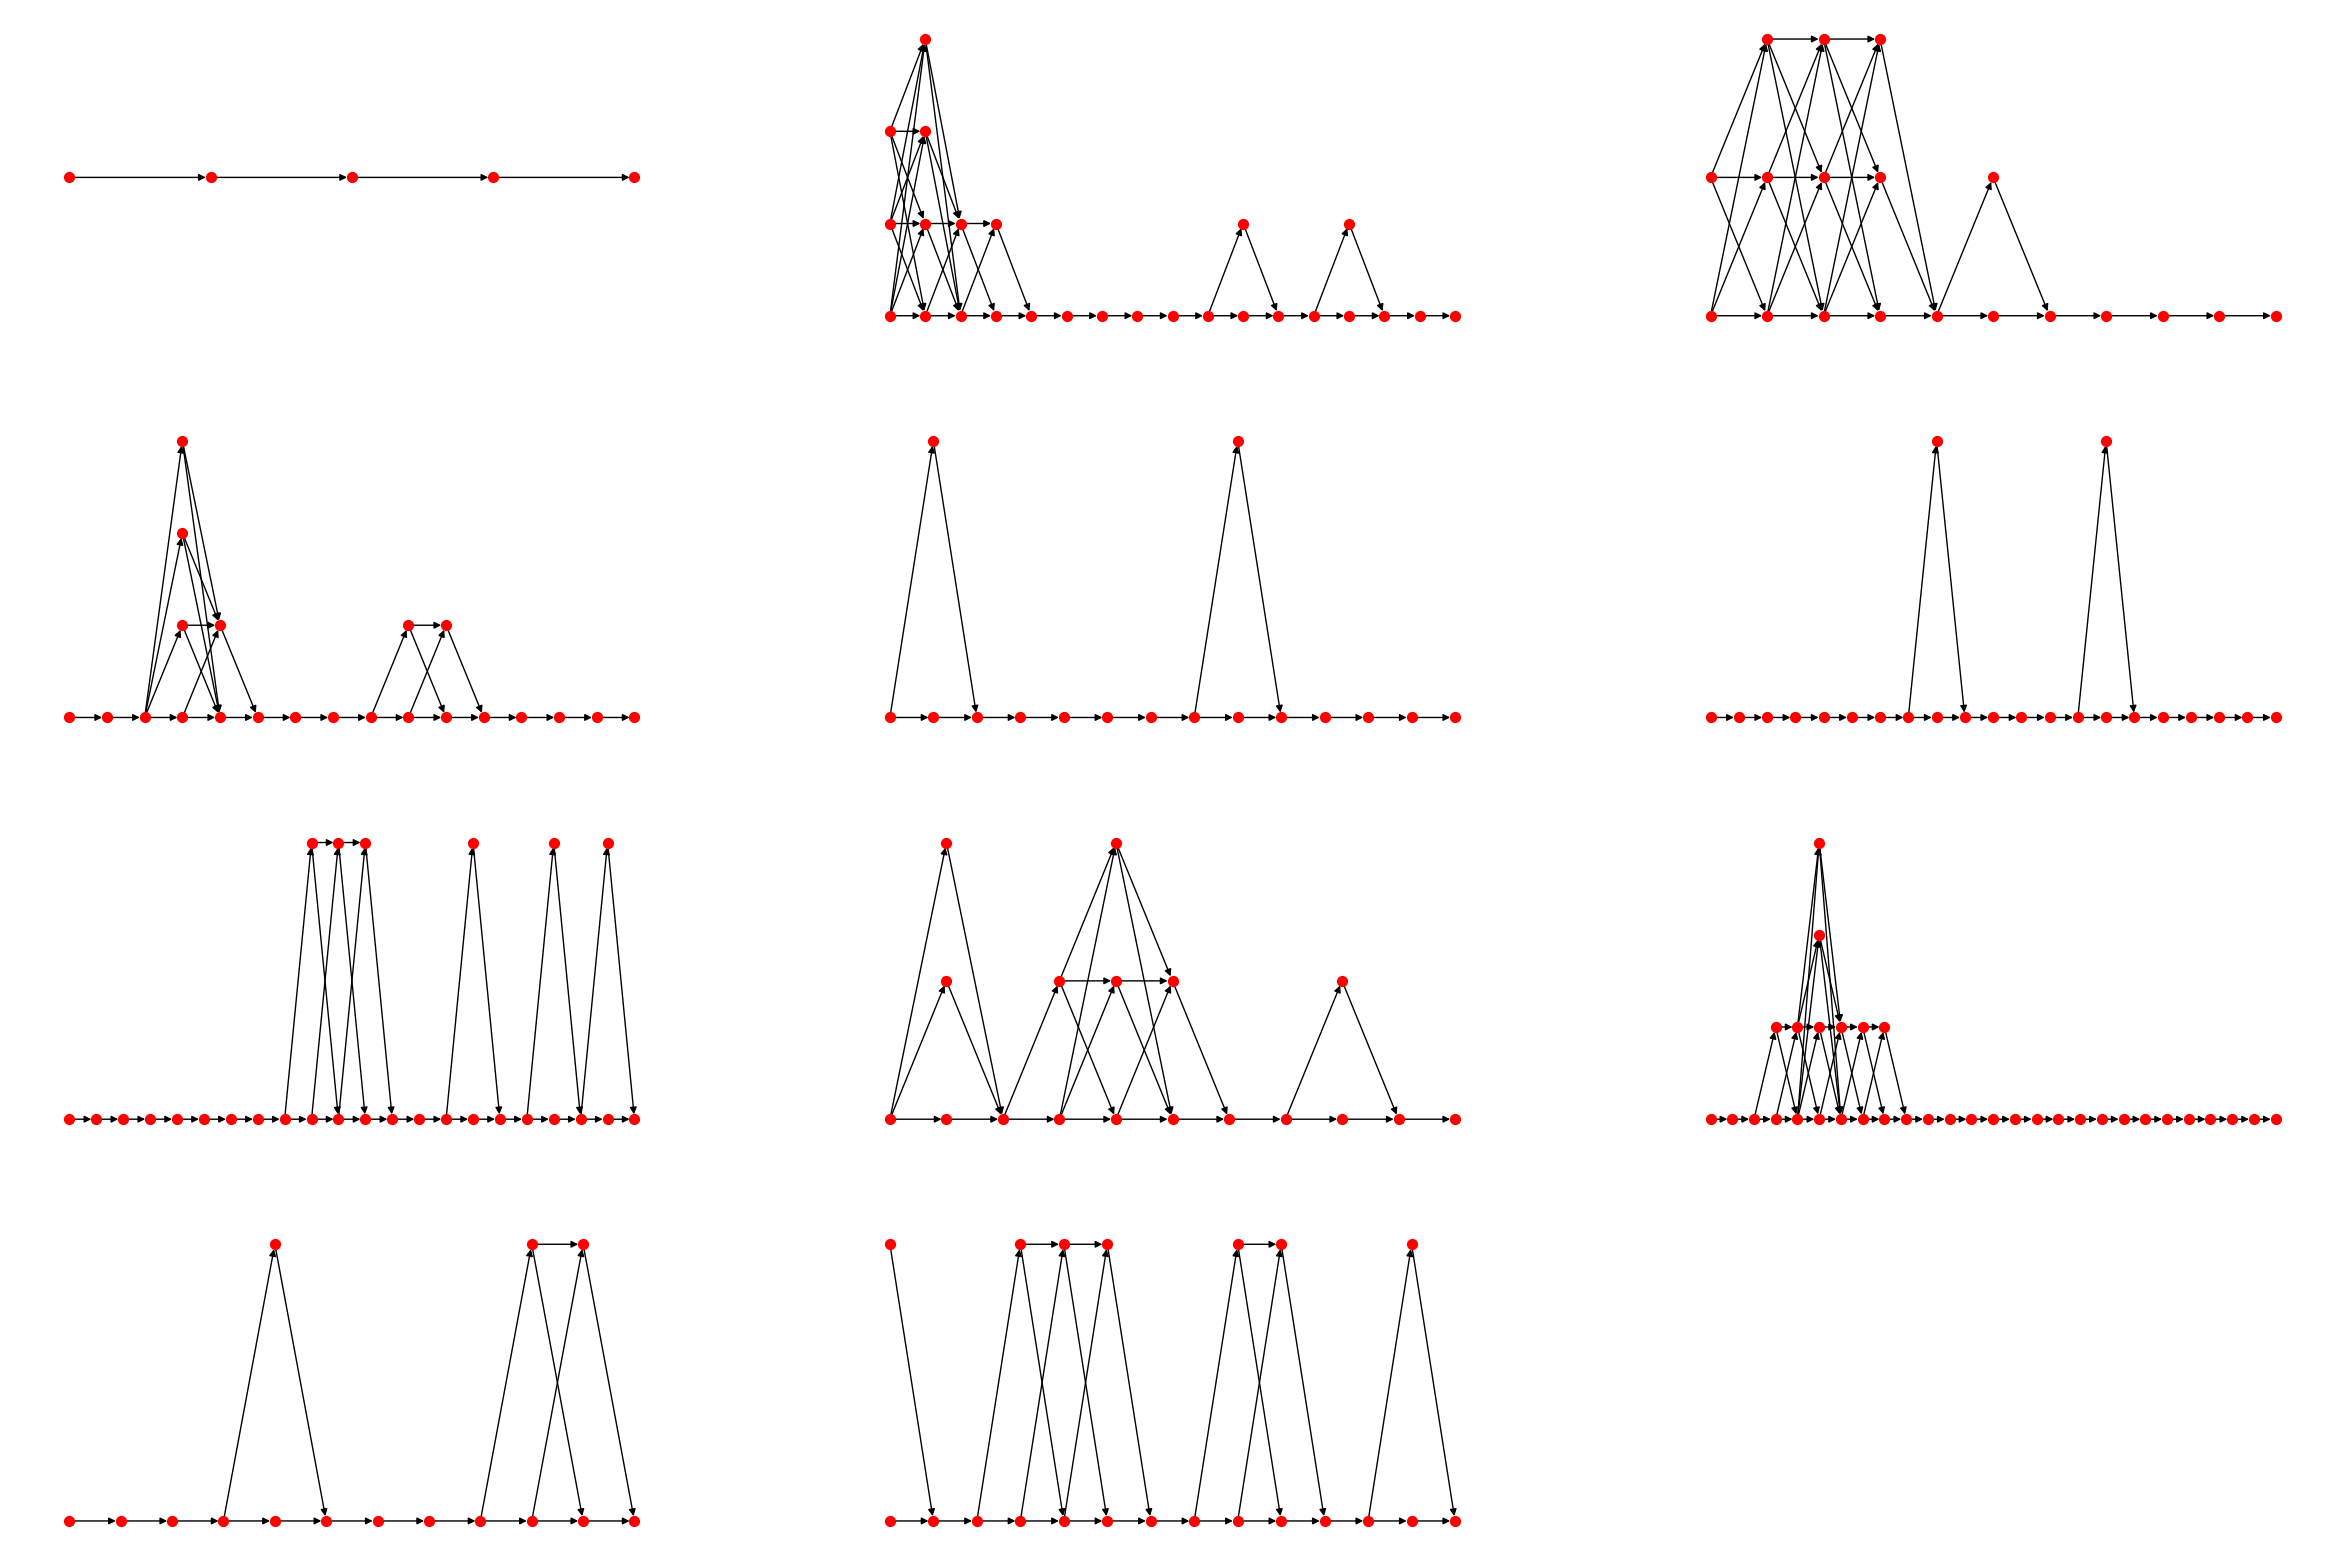

In [331]:
def draw_sequence(g, node_color='r', node_size=50):
    a = nx.to_numpy_array(g)
    pos = {}

    x = 0
    y = 0
    pos[0] = (x, y)
    for i in range(1, len(g)):
        if a[i-1, i] > 0.: 
            x += 1
            y = 0
        else : 
            y +=1
        pos[i] = (x, y)
    nx.draw(g, pos=pos, node_color=node_color, node_size=node_size)   

fig = plt.figure(figsize=(30, 20))
for (i, refit) in enumerate(refits):
    plt.subplot(4, 3, i+1)
    draw_sequence(graphs[refit])

print(refits)

In [332]:
dim = max([len(adjacency_mat[refit]) for refit in refits])
dataset = {refit:{} for refit in refits}

for refit in refits:
    a = adjacency_mat[refit]    

    
    a_new = np.zeros((dim, dim))
    a_new[:len(a), :][:, :len(a)] = a #embedding the graph in the common dimension
    dataset[refit]  = a_new

print(dataset[refits[0]])

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Distance matrix

In [333]:
def permutation_mat(permutation):
    mat = np.zeros((len(permutation), len(permutation)))
    for (i, j) in enumerate(permutation): mat[i, j] = 1.
    return(mat)

def graph_quotient_distance(a, b):
    res = quadratic_assignment(a, b, method='faq', options={'maximize': 'True',})
    return(np.linalg.norm(a)**2 - 2. * res.fun + np.linalg.norm(b)**2)

In [334]:
squared_distance_mat = np.array([[int(graph_quotient_distance(dataset[ri], dataset[rj])) for ri in refits] for rj in refits])
print('Squared distance matrix =')
print(squared_distance_mat)
distance_mat = np.sqrt(np.minimum(squared_distance_mat, squared_distance_mat.transpose()) - np.diag(np.diagonal(squared_distance_mat)))
print(' ')
print('Symmetrized squared distance matrix =')
print(distance_mat**2)

Squared distance matrix =
[[ 0 40 33 28 13 19 31 24 53 13 24]
 [40  6 27 26 29 25 27 28 33 29 20]
 [33 31  0 25 24 33 36 21 38 24 25]
 [28 20 25  9 21 18 27 31 32 14 13]
 [13 31 24 25 10 14 28 17 36 10 23]
 [19 27 35 24 14  7 24 28 33 19 24]
 [39 29 28 23 22 20  0 27 32 28 19]
 [24 28 21 21 17 24 25  0 35 20 19]
 [47 27 40 30 38 35 30 33  0 37 44]
 [13 31 26 16 12 21 24 18 39  0 12]
 [26 24 27 17 21 20 21 23 30 12  0]]
 
Symmetrized squared distance matrix =
[[ 0. 40. 33. 28. 13. 19. 31. 24. 47. 13. 24.]
 [40.  0. 27. 20. 29. 25. 27. 28. 27. 29. 20.]
 [33. 27.  0. 25. 24. 33. 28. 21. 38. 24. 25.]
 [28. 20. 25.  0. 21. 18. 23. 21. 30. 14. 13.]
 [13. 29. 24. 21.  0. 14. 22. 17. 36. 10. 21.]
 [19. 25. 33. 18. 14.  0. 20. 24. 33. 19. 20.]
 [31. 27. 28. 23. 22. 20.  0. 25. 30. 24. 19.]
 [24. 28. 21. 21. 17. 24. 25.  0. 33. 18. 19.]
 [47. 27. 38. 30. 36. 33. 30. 33.  0. 37. 30.]
 [13. 29. 24. 14. 10. 19. 24. 18. 37.  0. 12.]
 [24. 20. 25. 13. 21. 20. 19. 19. 30. 12.  0.]]


# Multi-dimensional scaling

In [335]:
def plot_mds(distance_mat, labels):
    multidimensional_scaling = MDS(n_components=2, dissimilarity='precomputed', normalized_stress=False)
    embedding = multidimensional_scaling.fit_transform(distance_mat)
    embedding = embedding / np.max(embedding)

    fig = plt.figure(figsize=(15, 15))
    plt.plot(embedding[:, 0], embedding[:, 1], 'ko')
    plt.axis('equal')
    plt.axis('off')
    
    for (i, coo) in enumerate(embedding): plt.text(coo[0], coo[1]+.05, labels[i])

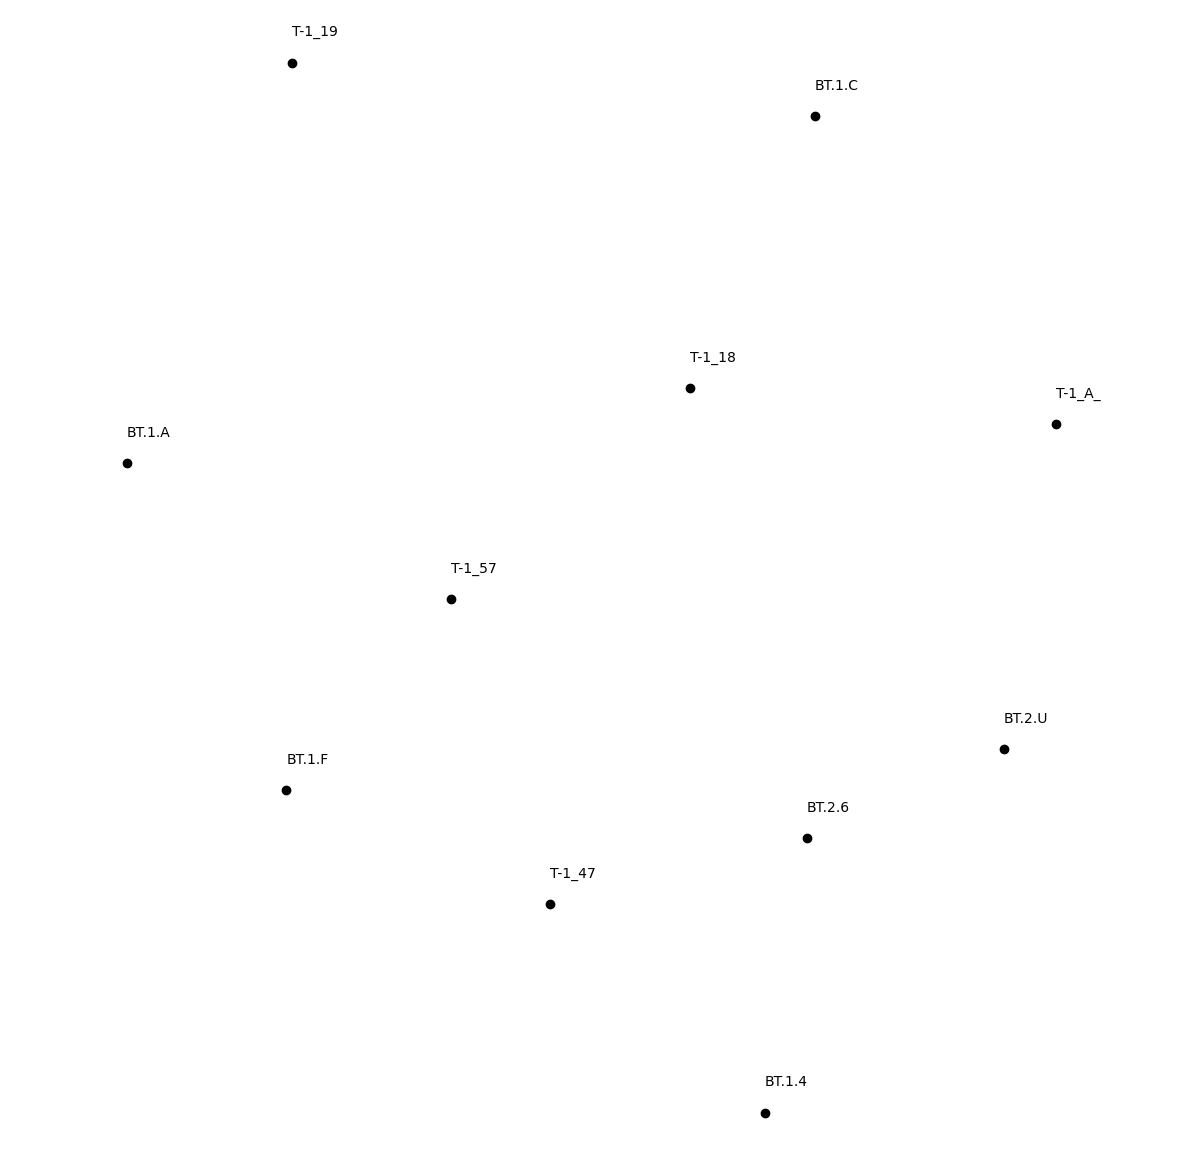

In [336]:
plot_mds(distance_mat, refits)

# Diffusion maps

In [337]:
def plot_diffusion_maps(distance_mat, labels, eps='auto', alpha=.5):
    if eps=='auto': eps = np.mean(distance_mat ** 2)
    L = np.exp(- distance_mat ** 2 / eps)
    D = np.diag(np.sum(L, axis=0))
    L_alpha = np.linalg.inv(D ** alpha) @ L @ np.linalg.inv(D ** alpha)
    D_alpha = np.diag(np.sum(L_alpha, axis=0))
    M = np.linalg.inv(D_alpha) @ L_alpha
    l, e = np.linalg.eigh(M.transpose())
    print(l)
    embedding = e[:, -2:]

    fig = plt.figure(figsize=(15, 15))
    plt.plot(embedding[:, 0], embedding[:, 1], 'ko')
    plt.axis('equal')
    plt.axis('off')
    
    for (i, coo) in enumerate(embedding): plt.text(coo[0], coo[1]+.05, labels[i])

[0.04838749 0.0753221  0.08290998 0.1147287  0.12637534 0.13822895
 0.16908758 0.20076105 0.23232096 0.32536158 1.00996249]


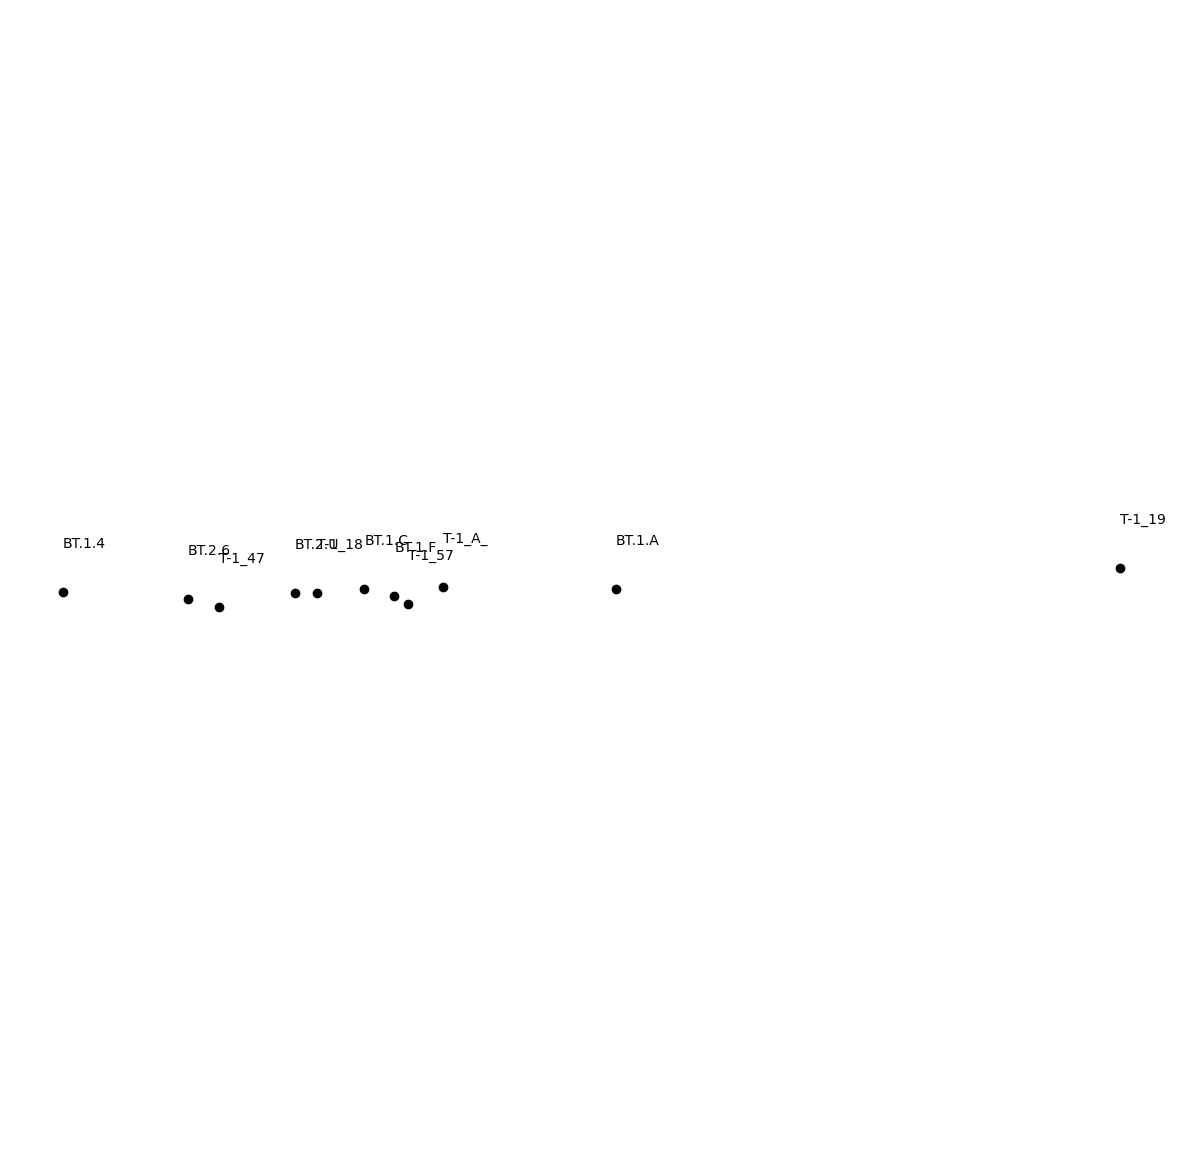

In [338]:
plot_diffusion_maps(distance_mat, refits)

# Clustering

In [339]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)

def plot_hierachical_clustering(distance_mat, labels):
    clustering = AgglomerativeClustering(metric='precomputed', linkage='complete', compute_distances=True).fit(distance_mat)
    fig = plt.figure(figsize=(15, 10))
    plot_dendrogram(clustering, truncate_mode="level", color_threshold=0, labels=labels, above_threshold_color='k')

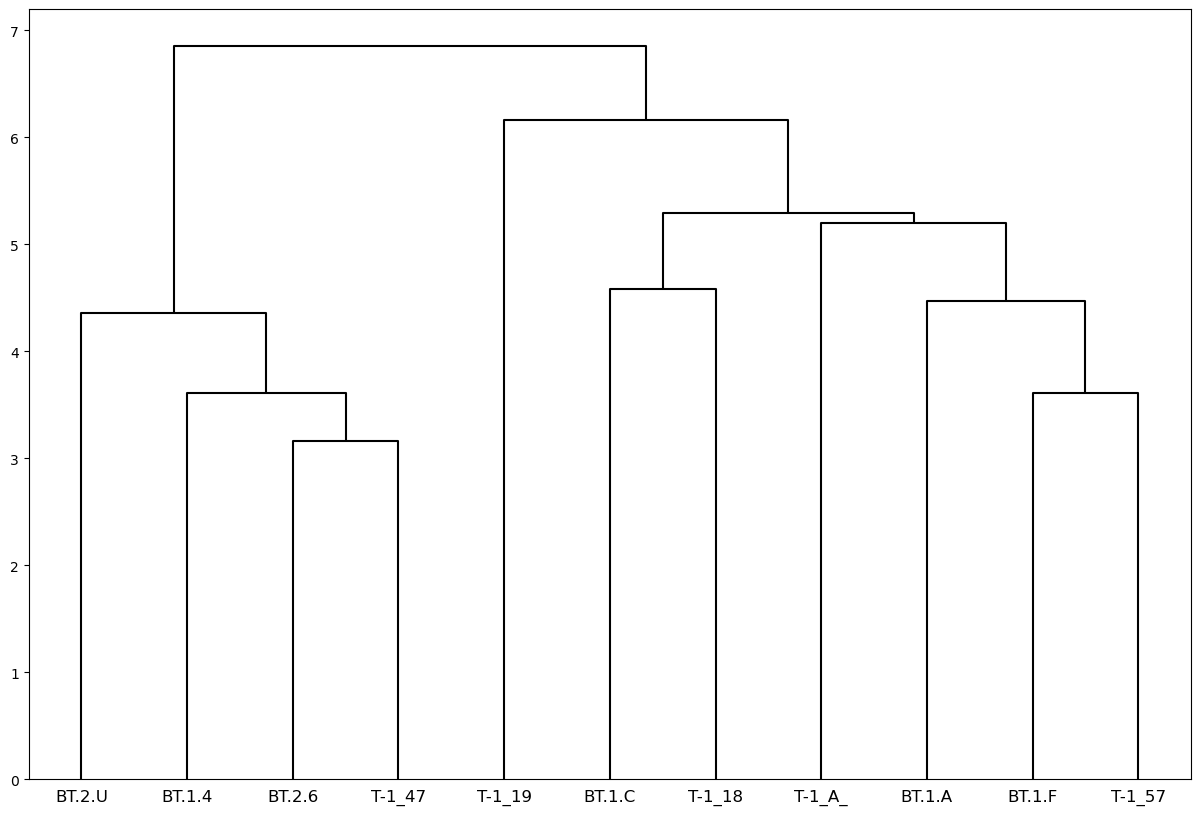

In [340]:
plot_hierachical_clustering(distance_mat, refits)